**Problem Statement**

- Salary prediction of nurses
- part-time/non-regular jobs are out of scope, target nurses are
    - `REGISTERED NURSE`,
    - `LICENSED VOCATIONAL NURSE`
    - `NURSING ASSISTANT`
    - `NURSE MANAGER`
    - `PUBLIC HEALTH NURSE`
- only nurses who work more than 5 years

# Import

In [1]:
import pandas as pd
import numpy as np

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Load raw data

- including not only nurses but also other jobs 
- uppercase all names and job titles 

In [192]:
rawdata = pd.read_csv('./data/san-francisco-payroll_2011-2019.csv',low_memory=False)
rawdata['Employee Name']=rawdata['Employee Name'].map(str.upper).map(str.strip).replace('  ',' ', regex=True).replace('[^A-Za-z0-9 ]', '', regex=True)
rawdata['Job Title']=rawdata['Job Title'].map(str.upper).map(str.strip).replace('  ',' ', regex=True).replace('[^A-Za-z ]', '', regex=True)
rawdata.head()

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,JANET LEE MILLER,COURT STAFF ATTORNEY II,0.0,0.0,0.0,0.0,0.00,0.00,2019,PT
1,GARY MAR,ELECTRICAL TRANSIT SYSTEM MECH,97354.53,6996.5,2380.0,38855.9,106731.03,145586.93,2019,FT
2,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,86118.0,17212.96,7272.08,34942.38,110603.04,145545.42,2019,FT
3,KRISTIAN C SMOCK,STATIONARY ENG SEWAGE PLANT,106816.03,0.0,0.0,38729.65,106816.03,145545.68,2019,FT
4,YUN Y CHANG,PHARMACY TECHNICIAN,94039.13,14947.99,1241.69,35330.26,110228.81,145559.07,2019,FT


# Preprocessing

## filter only target nurses

In [3]:
NURSES = ['REGISTERED NURSE',
'LICENSED VOCATIONAL NURSE',
'NURSING ASSISTANT',
'NURSE MANAGER',
'PUBLIC HEALTH NURSE']

data = rawdata[rawdata['Job Title'].isin(NURSES)].reset_index(drop=True)
data.shape

(16502, 10)

## check duplicated employee name
- group by (employee name, year) -> must be 1

In [4]:
grouped = data.groupby(['Employee Name', 'Year']).count()['Job Title']
grouped

Employee Name        Year
AACE WU              2018    1
                     2019    1
AARON CRAMER         2011    1
                     2012    1
AARON LY             2015    1
                            ..
ZOSIMA P PANGILINAN  2017    1
                     2018    1
                     2019    1
ZOSIMA PANGILINAN    2011    1
                     2012    1
Name: Job Title, Length: 16497, dtype: int64

In [5]:
grouped[grouped > 1]

Employee Name        Year
MARGARITA HERRERA    2012    2
MARGARITA L HERRERA  2017    2
MARIA CRUZ           2012    2
NANCY KRAUSS         2012    2
XING C CUI           2017    2
Name: Job Title, dtype: int64

- `MARGARITA HERRERA` and `MARGARITA L HERRERA` may be identical

In [6]:
data[data['Employee Name'] == 'MARGARITA HERRERA']

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
14454,MARGARITA HERRERA,REGISTERED NURSE,17973.09,80.08,21.36,4245.6,18074.53,22320.13,2012,NaN
14732,MARGARITA HERRERA,PUBLIC HEALTH NURSE,50178.68,0.0,350.0,18195.87,50528.68,68724.55,2012,NaN
16245,MARGARITA HERRERA,PUBLIC HEALTH NURSE,1977.5,0.0,0.0,Not Provided,1977.50,1977.50,2011,NaN


In [7]:
data[data['Employee Name'] == 'MARGARITA L HERRERA']

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
1674,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,22808.0,0.0,250.0,4894.82,23058.00,27952.82,2019,PT
3624,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,20828.18,0.0,0.0,4117.76,20828.18,24945.94,2018,PT
5637,MARGARITA L HERRERA,REGISTERED NURSE,0.0,0.0,0.0,903.92,0.00,903.92,2017,PT
5823,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,50169.97,0.0,250.0,10577.52,50419.97,60997.49,2017,PT
7453,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,36995.41,0.00,250.00,12253.61,37245.41,49499.02,2016,NaN
11216,MARGARITA L HERRERA,REGISTERED NURSE,0.0,0.0,45906.8,14396.19,45906.80,60302.99,2014,PT
12771,MARGARITA L HERRERA,PUBLIC HEALTH NURSE,29433.11,0.0,150.0,9754.41,29583.11,39337.52,2013,NaN


In [8]:
## rename `MARGARITA L HERRERA`
data['Employee Name'] = data['Employee Name'].replace('MARGARITA L HERRERA', 'MARGARITA HERRERA')

In [9]:
## replaced
data[data['Employee Name'] == 'MARGARITA HERRERA']

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
1674,MARGARITA HERRERA,PUBLIC HEALTH NURSE,22808.0,0.0,250.0,4894.82,23058.00,27952.82,2019,PT
3624,MARGARITA HERRERA,PUBLIC HEALTH NURSE,20828.18,0.0,0.0,4117.76,20828.18,24945.94,2018,PT
5637,MARGARITA HERRERA,REGISTERED NURSE,0.0,0.0,0.0,903.92,0.00,903.92,2017,PT
5823,MARGARITA HERRERA,PUBLIC HEALTH NURSE,50169.97,0.0,250.0,10577.52,50419.97,60997.49,2017,PT
7453,MARGARITA HERRERA,PUBLIC HEALTH NURSE,36995.41,0.00,250.00,12253.61,37245.41,49499.02,2016,NaN
11216,MARGARITA HERRERA,REGISTERED NURSE,0.0,0.0,45906.8,14396.19,45906.80,60302.99,2014,PT
12771,MARGARITA HERRERA,PUBLIC HEALTH NURSE,29433.11,0.0,150.0,9754.41,29583.11,39337.52,2013,NaN
14454,MARGARITA HERRERA,REGISTERED NURSE,17973.09,80.08,21.36,4245.6,18074.53,22320.13,2012,NaN
14732,MARGARITA HERRERA,PUBLIC HEALTH NURSE,50178.68,0.0,350.0,18195.87,50528.68,68724.55,2012,NaN
16245,MARGARITA HERRERA,PUBLIC HEALTH NURSE,1977.5,0.0,0.0,Not Provided,1977.50,1977.50,2011,NaN


## filter only those who have 2019 salary

In [10]:
employees = data.groupby('Employee Name')['Year'].max() # latest year
employees = employees[employees == 2019] # only latest year == 2019
employees

Employee Name
AACE WU                2019
AARON LY               2019
AARON R RAINEY         2019
AARON S CRAMER         2019
ABIGAIL I ESPINO       2019
                       ... 
ZENAIDA L RAMOS        2019
ZERINA O BANGAWAN      2019
ZEXU FANG              2019
ZIYING TAN             2019
ZOSIMA P PANGILINAN    2019
Name: Year, Length: 2032, dtype: int64

In [11]:
data = data[data['Employee Name'].isin(employees.index)]
data

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,86118.0,17212.96,7272.08,34942.38,110603.04,145545.42,2019,FT
1,ANGELO D QUIOC,LICENSED VOCATIONAL NURSE,80359.21,32594.24,250.0,32412.48,113203.45,145615.93,2019,FT
2,LALAINE G SALARDA,NURSING ASSISTANT,80322.5,24657.58,6328.96,33617.75,111309.04,144926.79,2019,FT
3,SARA B COLE,REGISTERED NURSE,103416.69,0.0,499.97,41061.6,103916.66,144978.26,2019,PT
4,SHINO HONDA,REGISTERED NURSE,92256.88,13042.34,12087.06,28001.22,117386.28,145387.50,2019,PT
...,...,...,...,...,...,...,...,...,...,...
16421,TATYANA VOVCHOK,LICENSED VOCATIONAL NURSE,64795.23,0.0,200.0,Not Provided,64995.23,64995.23,2011,NaN
16430,MEGAN BRIZZOLARA,REGISTERED NURSE,53616.02,3743.9,6708.44,Not Provided,64068.36,64068.36,2011,NaN
16431,TATYANA LITVINOVA,REGISTERED NURSE,57450.0,775.57,5830.46,Not Provided,64056.03,64056.03,2011,NaN
16470,DENISE GOMEZ PADILLA,REGISTERED NURSE,39236.1,0.0,5337.41,Not Provided,44573.51,44573.51,2011,NaN


## filter only those who have same job title
- i.e. exclude those who change job title

In [12]:
employees = data.groupby('Employee Name')['Job Title'].nunique()
employees = employees[employees == 1]
employees

Employee Name
AACE WU                1
AARON LY               1
AARON R RAINEY         1
AARON S CRAMER         1
ABIGAIL I ESPINO       1
                      ..
ZENAIDA L RAMOS        1
ZERINA O BANGAWAN      1
ZEXU FANG              1
ZIYING TAN             1
ZOSIMA P PANGILINAN    1
Name: Job Title, Length: 1963, dtype: int64

In [13]:
data = data[data['Employee Name'].isin(employees.index)]
data

,Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Status
0,CHECIL A SALVOSA,LICENSED VOCATIONAL NURSE,86118.0,17212.96,7272.08,34942.38,110603.04,145545.42,2019,FT
1,ANGELO D QUIOC,LICENSED VOCATIONAL NURSE,80359.21,32594.24,250.0,32412.48,113203.45,145615.93,2019,FT
2,LALAINE G SALARDA,NURSING ASSISTANT,80322.5,24657.58,6328.96,33617.75,111309.04,144926.79,2019,FT
3,SARA B COLE,REGISTERED NURSE,103416.69,0.0,499.97,41061.6,103916.66,144978.26,2019,PT
4,SHINO HONDA,REGISTERED NURSE,92256.88,13042.34,12087.06,28001.22,117386.28,145387.50,2019,PT
...,...,...,...,...,...,...,...,...,...,...
16421,TATYANA VOVCHOK,LICENSED VOCATIONAL NURSE,64795.23,0.0,200.0,Not Provided,64995.23,64995.23,2011,NaN
16430,MEGAN BRIZZOLARA,REGISTERED NURSE,53616.02,3743.9,6708.44,Not Provided,64068.36,64068.36,2011,NaN
16431,TATYANA LITVINOVA,REGISTERED NURSE,57450.0,775.57,5830.46,Not Provided,64056.03,64056.03,2011,NaN
16470,DENISE GOMEZ PADILLA,REGISTERED NURSE,39236.1,0.0,5337.41,Not Provided,44573.51,44573.51,2011,NaN


## check datatype

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10255 entries, 0 to 16491
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee Name         10255 non-null  object 
 1   Job Title             10255 non-null  object 
 2   Base Pay              10255 non-null  object 
 3   Overtime Pay          10255 non-null  object 
 4   Other Pay             10255 non-null  object 
 5   Benefits              10255 non-null  object 
 6   Total Pay             10255 non-null  float64
 7   Total Pay & Benefits  10255 non-null  float64
 8   Year                  10255 non-null  int64  
 9   Status                7516 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 881.3+ KB


- why is `Base Play` string? 
- include `"Not Provided"`

In [15]:
## replace with 0 -> drop after
data = data.replace('Not Provided', 0)
data['Base Pay'] = data['Base Pay'].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10255 entries, 0 to 16491
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee Name         10255 non-null  object 
 1   Job Title             10255 non-null  object 
 2   Base Pay              10255 non-null  float64
 3   Overtime Pay          10255 non-null  object 
 4   Other Pay             10255 non-null  object 
 5   Benefits              10255 non-null  object 
 6   Total Pay             10255 non-null  float64
 7   Total Pay & Benefits  10255 non-null  float64
 8   Year                  10255 non-null  int64  
 9   Status                7516 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 881.3+ KB


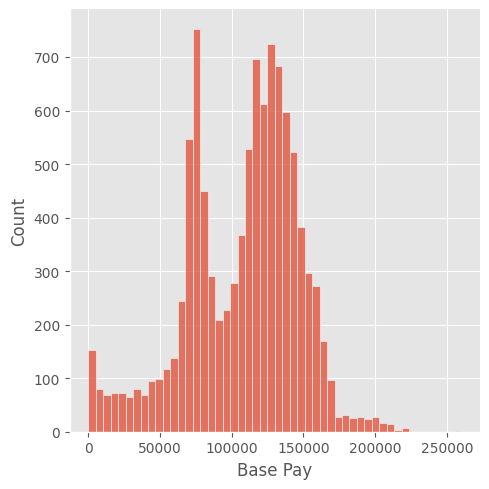

In [16]:
sns.displot(data['Base Pay'])
plt.show();

In [17]:
np.std(data['Base Pay'])

39280.17805697802

## create feature columns
- `Total Year`
- `Job Title`
- `Start Salary` 
- `2018 Salary`
- `Increase Rate` : (2018-start)/start
- `2019 Salary` 

In [18]:
def total_year(values):
    return max(values)-min(values)

df_totalyear = data.groupby(['Employee Name','Job Title'], as_index=False)['Year'].agg([total_year])
df_startsalary = data.groupby('Employee Name').apply(lambda x: x.sort_values('Year').iloc[0]['Base Pay']).rename('Start Salary')
df_salary2018 = data[data['Year']==2018].groupby('Employee Name')['Base Pay'].max()
df_salary2019 = data[data['Year']==2019].groupby('Employee Name')['Base Pay'].max()

len(df_totalyear), len(df_startsalary), len(df_salary2018), len(df_salary2019)

(1963, 1963, 1734, 1963)

In [19]:
def increase_rate(salary_2018, salary_start):
    try:
        return (salary_2018 - salary_start) / salary_start
    except:
        return None

df = pd.merge(df_totalyear, df_startsalary, how='inner', left_on='Employee Name', right_index=True)
df = pd.merge(df, df_salary2018, how='inner', left_on='Employee Name', right_index=True)
df = pd.merge(df, df_salary2019, how='inner', left_on='Employee Name', right_index=True)
df.columns = ['Total Year', 'Start Salary', '2018 Salary', '2019 Salary']
df.reset_index(inplace=True)
df['Increase Rate'] = df.apply(lambda row: increase_rate(row['2018 Salary'], row['Start Salary']), axis=1)
df = df[['Employee Name', 'Job Title', 'Total Year','Start Salary','2018 Salary', 'Increase Rate', '2019 Salary']]
df

,Employee Name,Job Title,Total Year,Start Salary,2018 Salary,Increase Rate,2019 Salary
0,AACE WU,REGISTERED NURSE,1,79549.99,79549.99,0.000000,56549.07
1,AARON LY,REGISTERED NURSE,4,41509.69,124342.52,1.995506,130451.27
2,AARON R RAINEY,REGISTERED NURSE,6,111472.90,38343.44,-0.656029,68799.78
3,AARON S CRAMER,REGISTERED NURSE,6,115372.35,138890.00,0.203841,143696.20
4,ABIGAIL I ESPINO,LICENSED VOCATIONAL NURSE,6,16254.50,81296.50,4.001477,81491.13
...,...,...,...,...,...,...,...
1729,ZARA GRACE C JANER,REGISTERED NURSE,6,107904.40,148215.14,0.373578,154205.11
1730,ZENAIDA L RAMOS,NURSING ASSISTANT,5,67948.00,10496.34,-0.845524,0.00
1731,ZERINA O BANGAWAN,REGISTERED NURSE,3,4127.90,138956.52,32.662763,142609.16
1732,ZEXU FANG,REGISTERED NURSE,8,109044.00,155789.00,0.428680,173489.51


## fitler only those who work at least 2 years

In [20]:
df = df[df['Total Year'] > 0].reset_index(drop=True)
df

,Employee Name,Job Title,Total Year,Start Salary,2018 Salary,Increase Rate,2019 Salary
0,AACE WU,REGISTERED NURSE,1,79549.99,79549.99,0.000000,56549.07
1,AARON LY,REGISTERED NURSE,4,41509.69,124342.52,1.995506,130451.27
2,AARON R RAINEY,REGISTERED NURSE,6,111472.90,38343.44,-0.656029,68799.78
3,AARON S CRAMER,REGISTERED NURSE,6,115372.35,138890.00,0.203841,143696.20
4,ABIGAIL I ESPINO,LICENSED VOCATIONAL NURSE,6,16254.50,81296.50,4.001477,81491.13
...,...,...,...,...,...,...,...
1729,ZARA GRACE C JANER,REGISTERED NURSE,6,107904.40,148215.14,0.373578,154205.11
1730,ZENAIDA L RAMOS,NURSING ASSISTANT,5,67948.00,10496.34,-0.845524,0.00
1731,ZERINA O BANGAWAN,REGISTERED NURSE,3,4127.90,138956.52,32.662763,142609.16
1732,ZEXU FANG,REGISTERED NURSE,8,109044.00,155789.00,0.428680,173489.51


# EDA

### distribution of `2019 Salary` by `Job Title`

### distribution of `Start Salary` and `2019 Salary`

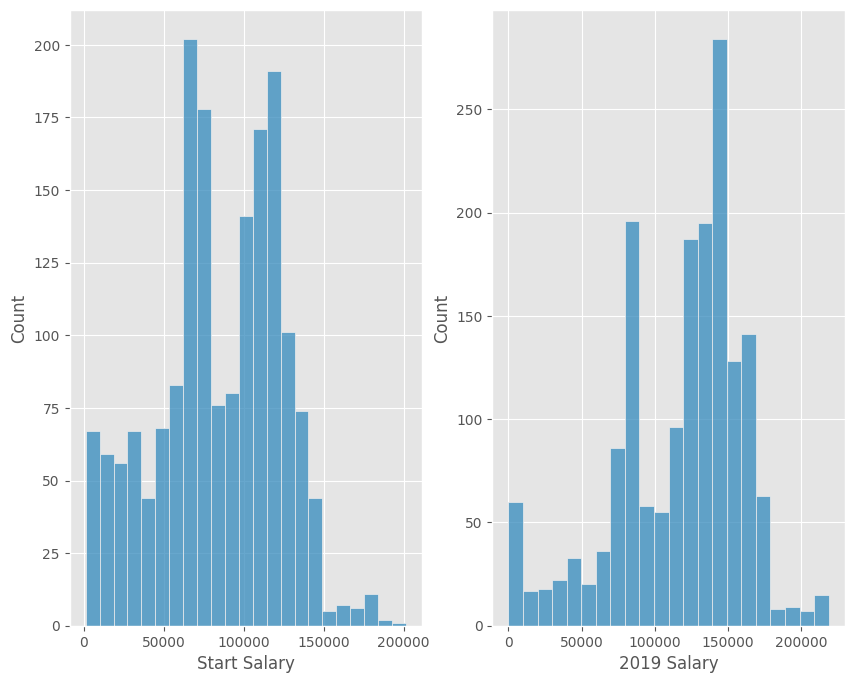

In [21]:
fig, axes = plt.subplots(1,2, figsize=(10, 8))
sns.histplot(ax=axes[0], x=df['Start Salary'])
sns.histplot(ax=axes[1], x=df['2019 Salary'])
plt.show();

- **There are 2 peaks**
- Salary should not be less than 10000$, it's below minimum wage of full-time worker
- Such data is not a outlier, but incorrect data -> we can drop from both train and test  
- some people do not work whole year, that may cause this incorrectness

In [22]:
## drop salary < 10000

df = df[(df['2019 Salary'] > 10000) & (df['Start Salary'] > 10000)].reset_index(drop=True)
df

,Employee Name,Job Title,Total Year,Start Salary,2018 Salary,Increase Rate,2019 Salary
0,AACE WU,REGISTERED NURSE,1,79549.99,79549.99,0.000000,56549.07
1,AARON LY,REGISTERED NURSE,4,41509.69,124342.52,1.995506,130451.27
2,AARON R RAINEY,REGISTERED NURSE,6,111472.90,38343.44,-0.656029,68799.78
3,AARON S CRAMER,REGISTERED NURSE,6,115372.35,138890.00,0.203841,143696.20
4,ABIGAIL I ESPINO,LICENSED VOCATIONAL NURSE,6,16254.50,81296.50,4.001477,81491.13
...,...,...,...,...,...,...,...
1607,YVONNE FUENTESPATTISHALL,REGISTERED NURSE,7,119409.99,155264.01,0.300260,164250.50
1608,ZAR N MAW,REGISTERED NURSE,1,64910.38,64910.38,0.000000,93285.77
1609,ZARA GRACE C JANER,REGISTERED NURSE,6,107904.40,148215.14,0.373578,154205.11
1610,ZEXU FANG,REGISTERED NURSE,8,109044.00,155789.00,0.428680,173489.51


In [23]:
job_count = df.groupby('Job Title')['Employee Name'].count().sort_values(ascending=False).to_frame().reset_index()

fig, axes = plt.subplots(1,2, figsize=(12, 6))
sns.boxplot(ax=axes[0], x='2019 Salary', y='Job Title', data=df, order=job_count['Job Title'])
sns.barplot(x='Employee Name', y='Job Title', data=job_count).set(\
            yticklabels=job_count['Employee Name'], xlabel='count', ylabel=None);

### pairplot

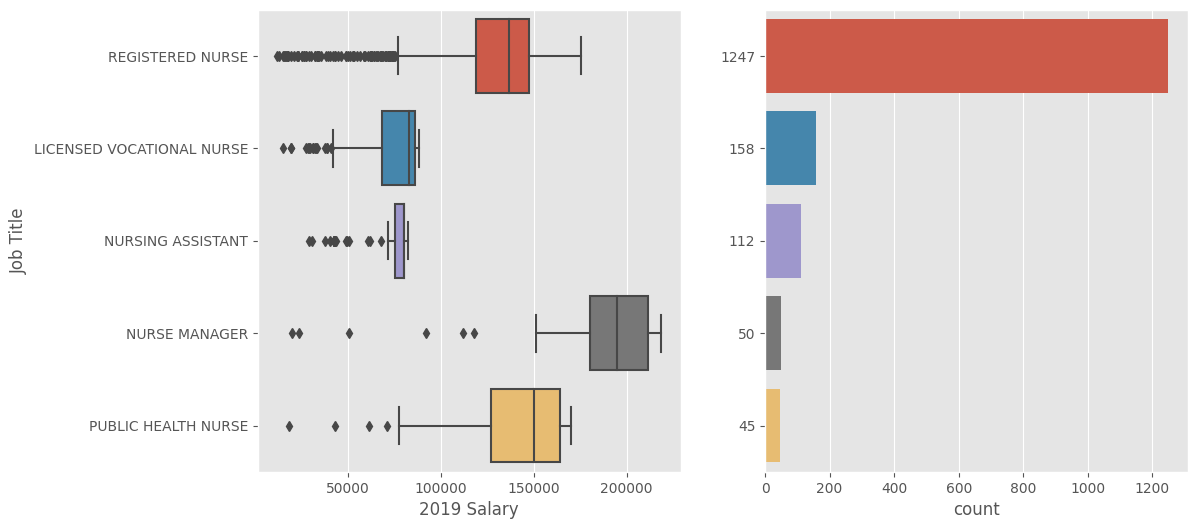

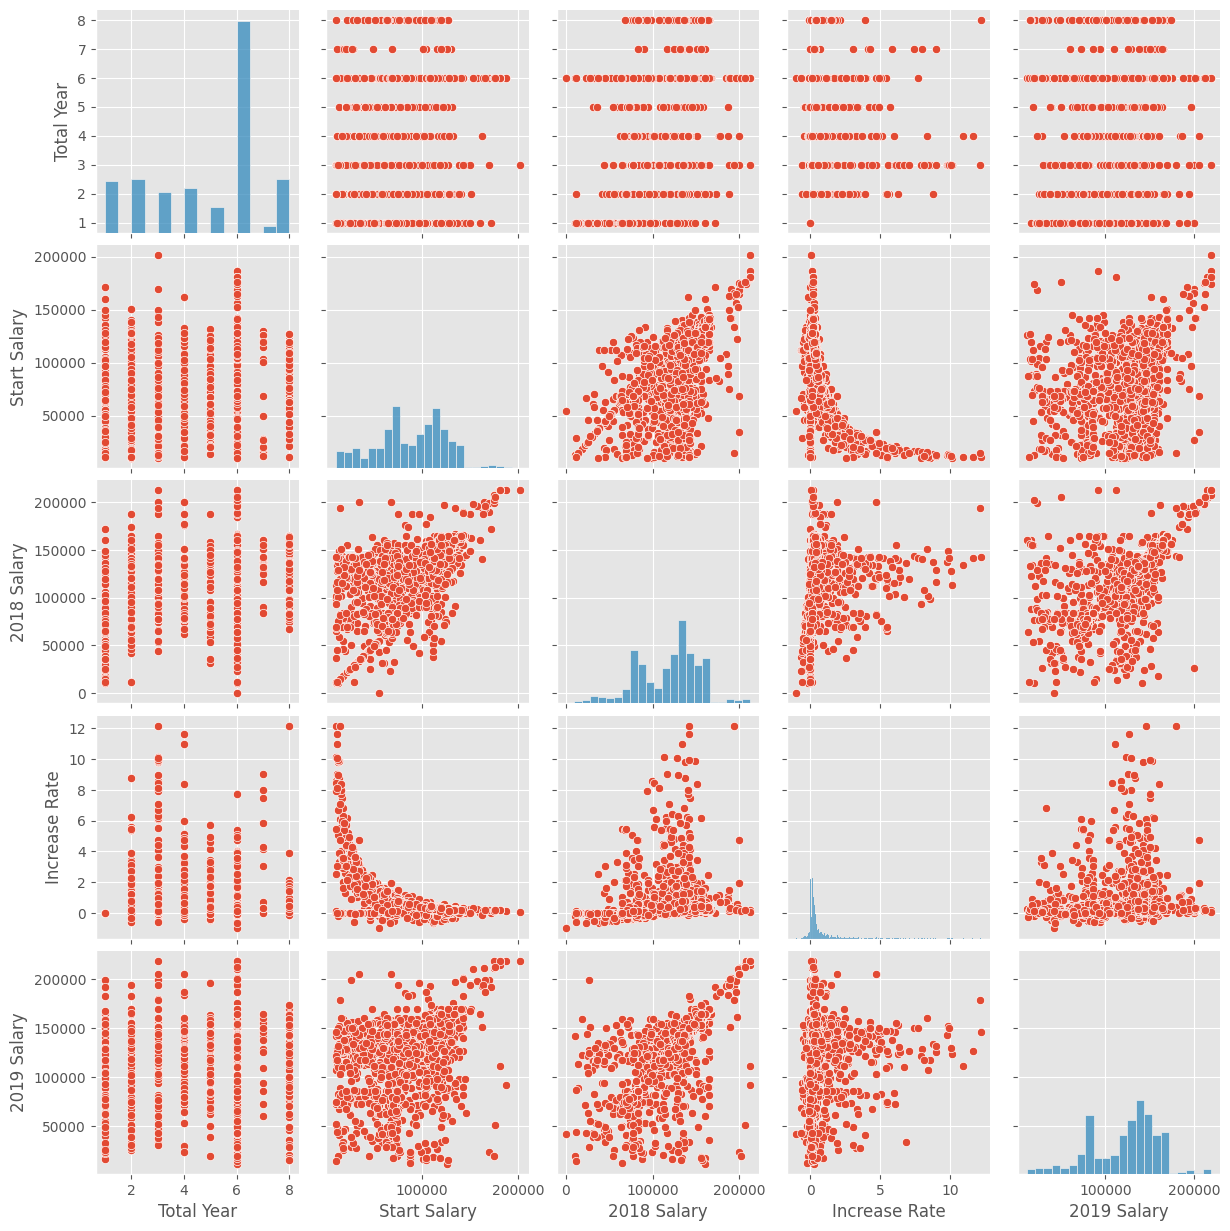

In [24]:
numeric_cols = ['Total Year', 'Start Salary','2018 Salary','Increase Rate', '2019 Salary']
sns.pairplot(df[numeric_cols])
plt.show();

### correlation

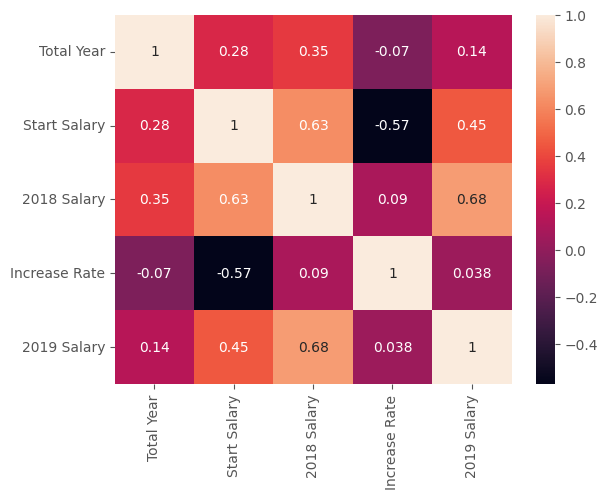

In [25]:
numeric_cols = ['Total Year', 'Start Salary','2018 Salary','Increase Rate', '2019 Salary']
sns.heatmap(df[numeric_cols].corr(), annot=True)
sns.color_palette("hls", 8)
plt.show();


### col_to_scale scatterplot `Start Salary` vs `2019 Salary` by `Job Title`

- hypothesis : for some job, it is likely to raise salary

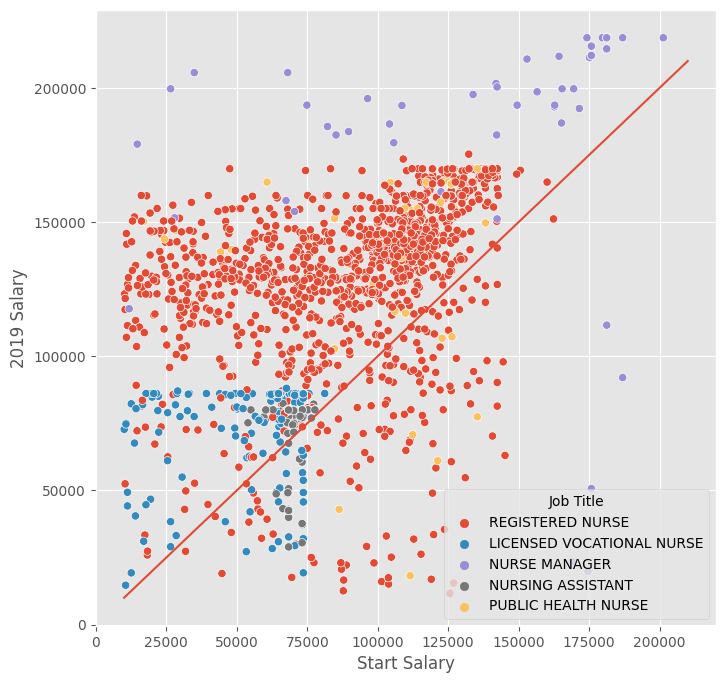

In [26]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='Start Salary', y='2019 Salary', hue='Job Title', data=df)
plt.plot([10000,210000],[10000,210000])
plt.show();

### col_to_scale scatterplot `Start Salary` vs `2019 Salary` by `Total Year`

- hypothesis : The longer they work, the more wage rise - True or Not??

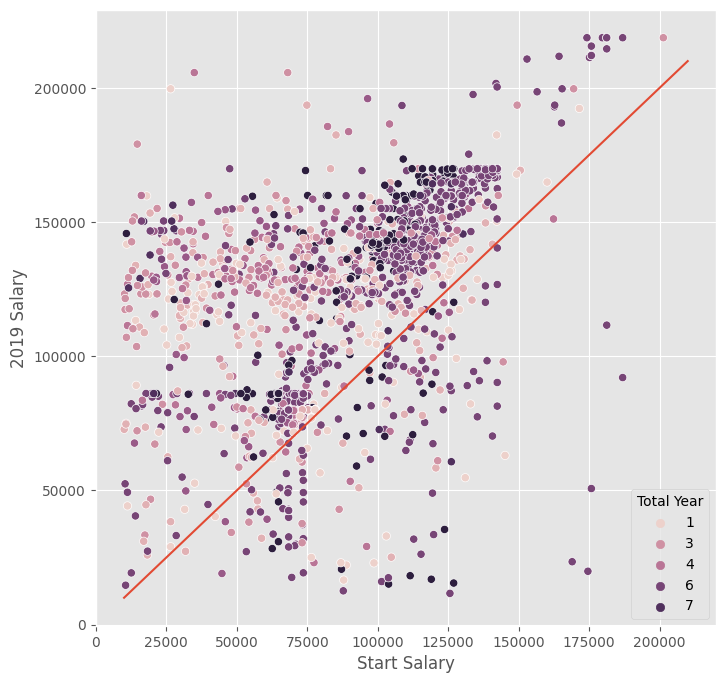

In [27]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='Start Salary', y='2019 Salary', hue='Total Year', data=df)
sns.color_palette("hls", 8)
plt.plot([10000,210000],[10000,210000])
plt.show();

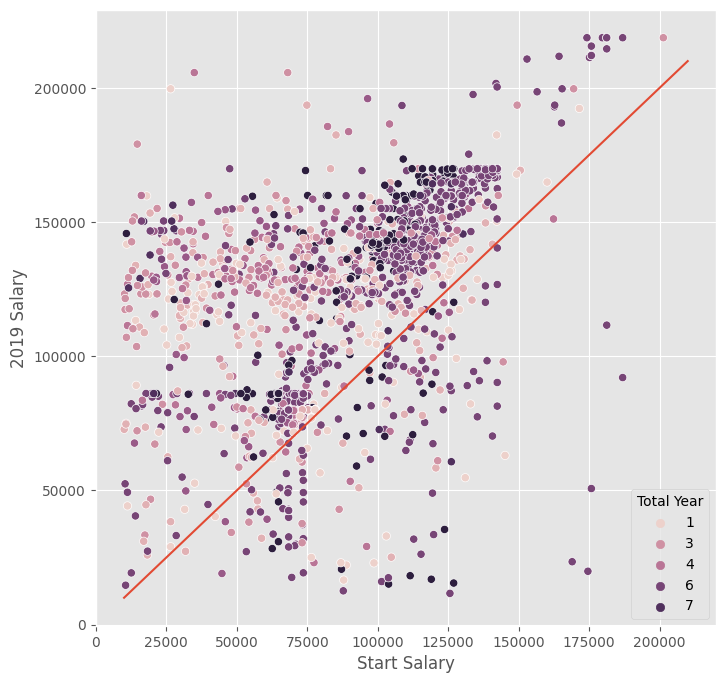

In [28]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='Start Salary', y='2019 Salary', hue='Total Year', data=df)
plt.plot([10000,210000],[10000,210000])
plt.show();

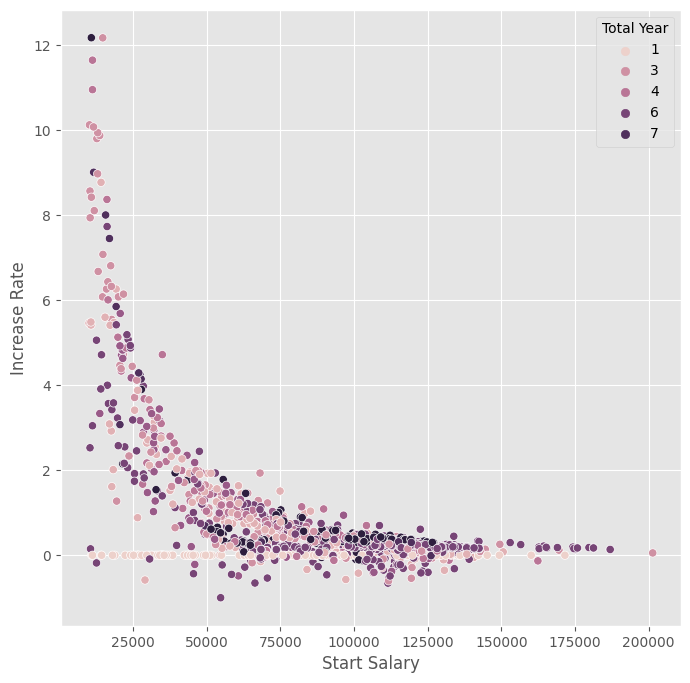

In [29]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='Start Salary', y='Increase Rate', hue='Total Year', data=df)
plt.show();

### Summary of EDA

......

# Modelling 1
- start from only 2 features : `Start Salary` and `Job Title`
- baseline : `Dummy Regressor`
- correlation between `Start Salary` and `2019 Salary` is 0.49

## train-test split

In [113]:
X = df[['Start Salary', 'Job Title']]
y = df['2018 Salary']

In [114]:
## stratify = X['Job Title'] because some Job Title are few data
## make array of original Job Title because it will be dummied up  
X_train, X_test, y_train, y_test, job_train, job_test = train_test_split(X, y, X['Job Title'], test_size=0.15, random_state=42, stratify=X['Job Title'])

## dummy up Job Title
X_train = pd.get_dummies(X_train, columns=['Job Title'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Job Title'], drop_first=True)

## check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1370, 5), (242, 5), (1370,), (242,))

In [115]:
## function for evaluation
def evaluate(model, X_test=X_test, y_test=y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE : {mae:.4f}')
    print(f'R2  : {r2:.4f}')

    residual = y_pred - y_test
    plt.scatter(y_test, residual)
    plt.ylabel('residual'); plt.xlabel('y_true')
    plt.show()

## Dummy Regressor - baseline score

RMSE: 35982.5821
MAE : 29252.5623
R2  : -0.0002


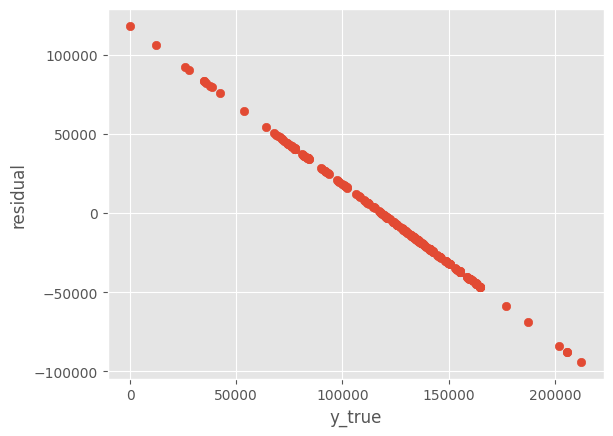

In [116]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)

evaluate(dummy)

## Linear Regression

RMSE: 22395.6616
MAE : 15653.6860
R2  : 0.6125


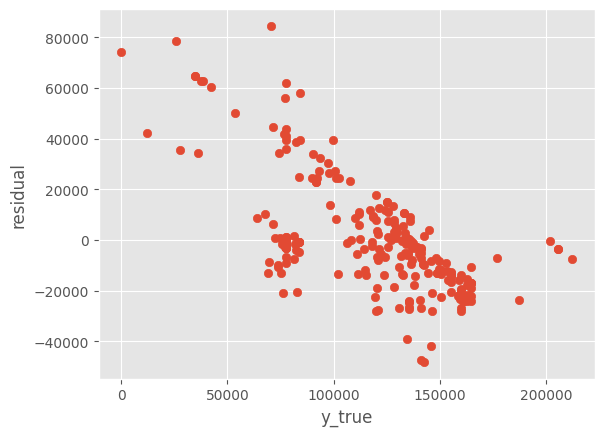

In [117]:
lr = LinearRegression()
lr.fit(X_train, y_train)

evaluate(lr)

- score is better than dummy regressor
- **there are 2 lines**
- for lower salary, predict > actual
- for higher salary, predict < actual

-> **check distribution of each job**

In [118]:
def plot_predict_by_job(model, X_test=X_test, y_test=y_test):
    y_pred = model.predict(X_test)
    temp_df = pd.DataFrame({'pred':y_pred,'true':y_test,'Job Title':job_test})
    plt.figure(figsize=(10,10))
    sns.scatterplot(x='true',y='pred',hue='Job Title',data=temp_df)
    plt.plot([20000,210000],[20000,210000])
    plt.show();

In [119]:
# plt.figure(figsize=(10,10))
# sns.scatterplot(x='true',y='pred',hue='Job Title',data=temp_df)
# plt.plot([20000,210000],[20000,210000])
# plt.show();

- clusters are clear. predicted values are strongly correlated with `Job Title`
- i.e. for the same Job Title, the model predicts similar values

# Modelling 2
- try to use `Total Year`

In [123]:
X = df[['Start Salary', 'Total Year', 'Job Title']]
y = df['2018 Salary']

## stratify = X['Job Title'] because some Job Title are few data
## make array of original Job Title because it will be dummied up  
X_train, X_test, y_train, y_test, job_train, job_test = train_test_split(X, y, X['Job Title'], test_size=0.15, random_state=42, stratify=X['Job Title'])

## dummy up Job Title
X_train = pd.get_dummies(X_train, columns=['Job Title'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Job Title'], drop_first=True)

## check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1370, 6), (242, 6), (1370,), (242,))

In [124]:
X_train.columns

Index(['Start Salary', 'Total Year', 'Job Title_NURSE MANAGER',
       'Job Title_NURSING ASSISTANT', 'Job Title_PUBLIC HEALTH NURSE',
       'Job Title_REGISTERED NURSE'],
      dtype='object')

RMSE: 21876.7184
MAE : 15516.2586
R2  : 0.6303


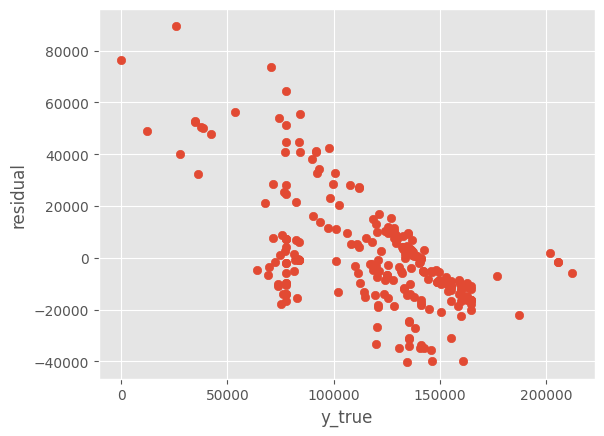

In [125]:
## Linear Regression with scaling
col_to_scale = ['Start Salary']

sc = StandardScaler()

X_train_sc = X_train.copy()
X_train_sc[col_to_scale] = sc.fit_transform(X_train[col_to_scale])

X_test_sc = X_test.copy()
X_test_sc[col_to_scale] = sc.transform(X_test[col_to_scale])

lr = LinearRegression()
lr.fit(X_train_sc, y_train)

evaluate(lr, X_test=X_test_sc)

In [126]:
## coefficients
pd.DataFrame({'coef':lr.coef_}, index=lr.feature_names_in_)

,coef
Start Salary,12425.559177
Total Year,4838.086406
Job Title_NURSE MANAGER,86415.824063
Job Title_NURSING ASSISTANT,3745.895455
Job Title_PUBLIC HEALTH NURSE,47499.587525
Job Title_REGISTERED NURSE,42039.123682


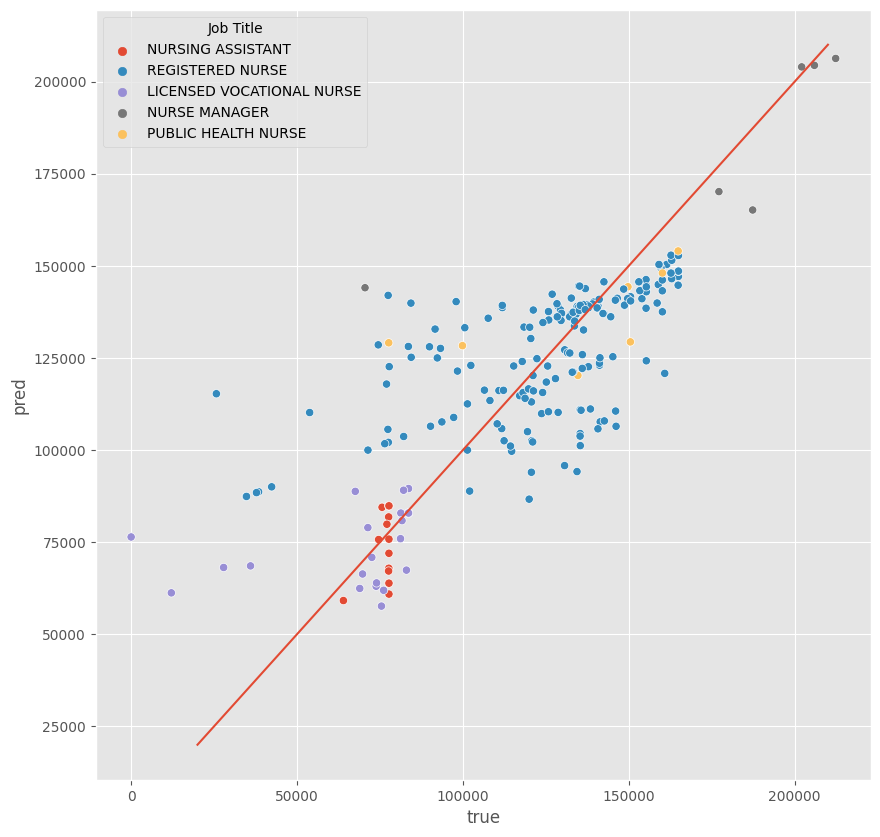

In [127]:
plot_predict_by_job(lr, X_test=X_test_sc)
plt.show()

- Is this model better than previous model?

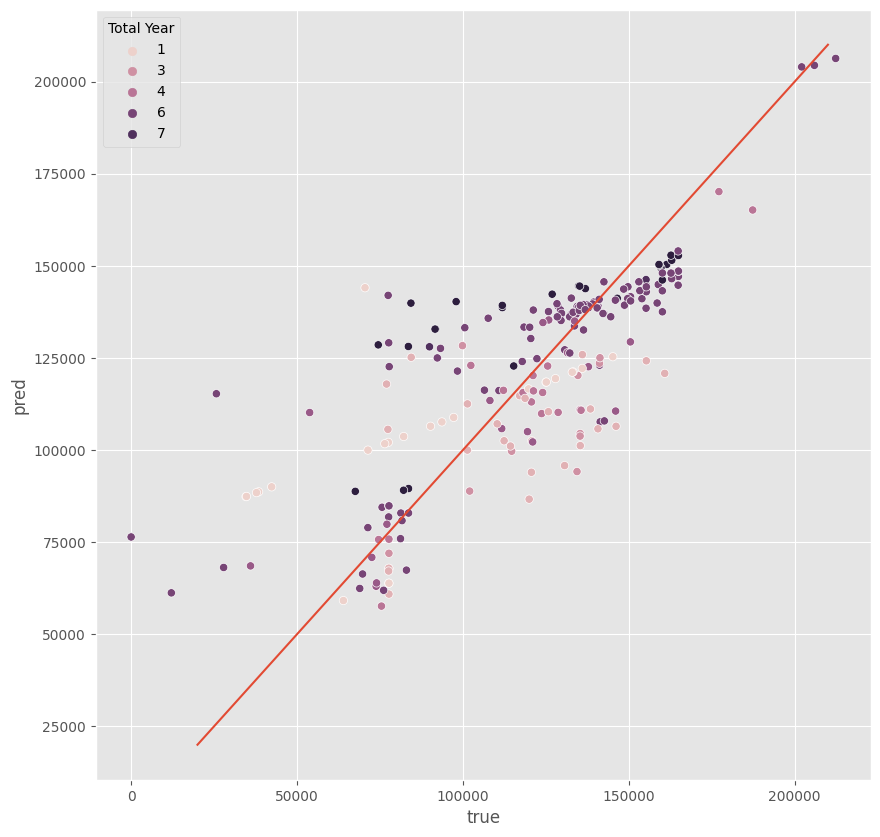

In [128]:
def plot_predict_by_totalyear(model, X_test=X_test, y_test=y_test):
    y_pred = model.predict(X_test)
    temp_df = pd.DataFrame({'pred':y_pred,'true':y_test,'Total Year':X_test['Total Year']})
    plt.figure(figsize=(10,10))
    sns.scatterplot(x='true',y='pred',hue='Total Year',data=temp_df)
    plt.plot([20000,210000],[20000,210000])
    
plot_predict_by_totalyear(lr, X_test_sc)
plt.show()

- Does `Total Year` form cluster?

# Model DecisionTreeRegressor

In [223]:
X = df[['Start Salary', 'Total Year', 'Job Title']]
y = df['2019 Salary']



In [224]:
## stratify = X['Job Title'] because some Job Title are few data
## make array of original Job Title because it will be dummied up  
X_train, X_test, y_train, y_test, job_train, job_test = train_test_split(X, y, X['Job Title'], test_size=0.15, random_state=42, stratify=X['Job Title'])



In [225]:
## dummy up Job Title
X_train = pd.get_dummies(X_train, columns=['Job Title'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Job Title'], drop_first=True)



In [226]:
## check shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1370, 6), (242, 6), (1370,), (242,))

In [227]:
# Instantiate a Decision Tree Regressor and set the criterion
# Import model and metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

dtr = DecisionTreeRegressor(criterion='squared_error', max_depth=3)
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [228]:
# Make predictions of y using X_test
y_preds = dtr.predict(X_test)

In [229]:
# MEDV - Median value of owner-occupied homes in 1000's 
# KEEP THIS IN MIND
dtr_performance = pd.DataFrame({'Actual': y_test, 'Predicted': y_preds})

In [230]:

dtr_performance.head(10)

,Actual,Predicted
278,77388.87,76441.602437
1540,144067.48,117536.918297
549,86118.13,76441.602437
1087,79420.80,76441.602437
510,119006.53,117536.918297
401,85928.11,76441.602437
608,129560.22,117536.918297
46,93960.26,136143.336264
1467,153481.52,136143.336264
227,77506.21,76441.602437


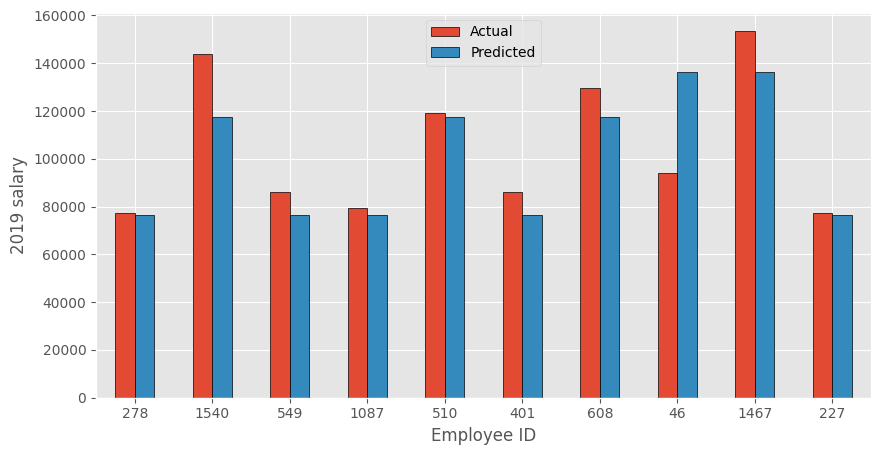

In [231]:
dtr_performance.head(10).plot(kind='bar', figsize=(10,5), 
                              edgecolor='#000000')
plt.xticks(rotation=0)
plt.ylabel('2019 salary')
plt.xlabel('Employee ID')
plt.show();


RMSE: 29965.7663
MAE : 22261.7017
R2  : 0.3063


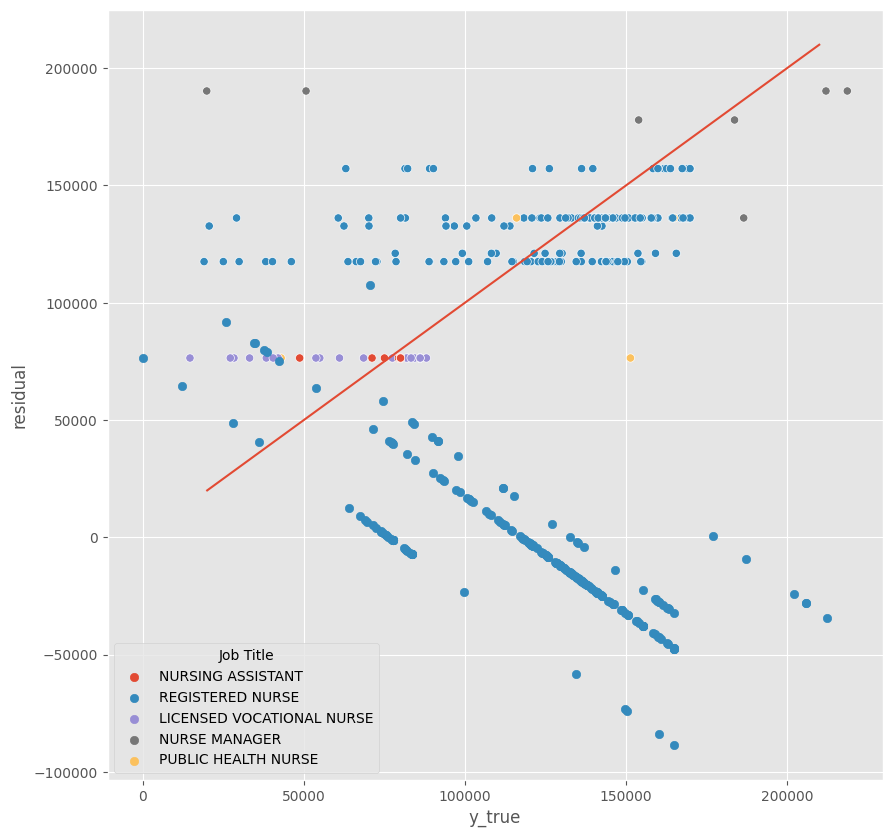

In [232]:
temp_df = pd.DataFrame({'pred':y_preds,'true':y_test,'Job Title':job_test})
plt.figure(figsize=(10,10))
sns.scatterplot(x='true',y='pred',hue='Job Title',data=temp_df)
plt.plot([20000,210000],[20000,210000])
evaluate(dtr, X_test=X_test_sc)
plt.show();


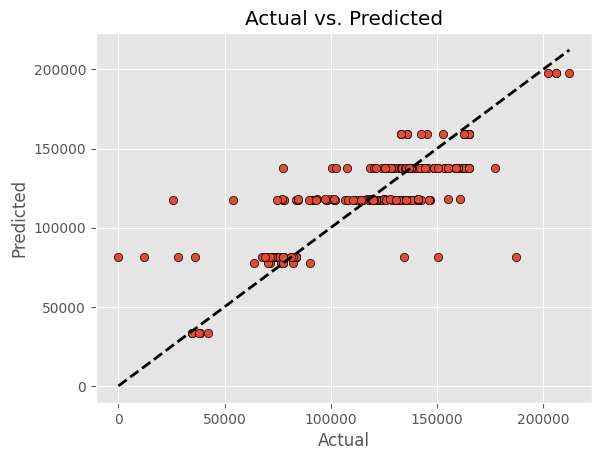

In [139]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_preds, edgecolor='#000000')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
       'k--', lw=2)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs. Predicted')
plt.show();


In [140]:
metrics.mean_squared_error(y_test, y_preds)

441375946.4572956

In [141]:
print(f'Mean Absolute Error: \
      {metrics.mean_absolute_error(y_test, y_preds)}')

print(f'Mean Squared Error: \
      {metrics.mean_squared_error(y_test, y_preds)}')

print(f'R Squared : \
      {metrics.r2_score(y_test, y_preds)}')

print(f'Root Mean Squared Error: \
      {metrics.mean_squared_error(y_test, y_preds, squared=False)}')

Mean Absolute Error:       13949.447828373148
Mean Squared Error:       441375946.4572956
R Squared :       0.6590328055740221
Root Mean Squared Error:       21008.949199264956


## Random

In [142]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr = RandomForestRegressor()

regr.fit(X_train, y_train)

RandomForestRegressor()

In [143]:
#Make predictions of y using X_test
y_preds = regr.predict(X_test)

In [144]:
# KEEP THIS IN MIND
dtr_performance = pd.DataFrame({'Actual': y_test, 'Predicted': y_preds})

In [145]:
dtr_performance.head(10)

,Actual,Predicted
278,77612.30,73471.092950
1540,98345.17,133281.967500
549,83448.71,83530.690568
1087,75626.07,72116.914207
510,110844.69,148871.561900
401,83602.50,83343.576834
608,123705.08,126383.994300
46,153940.09,142768.522600
1467,128642.99,133371.424400
227,73846.61,49386.591200


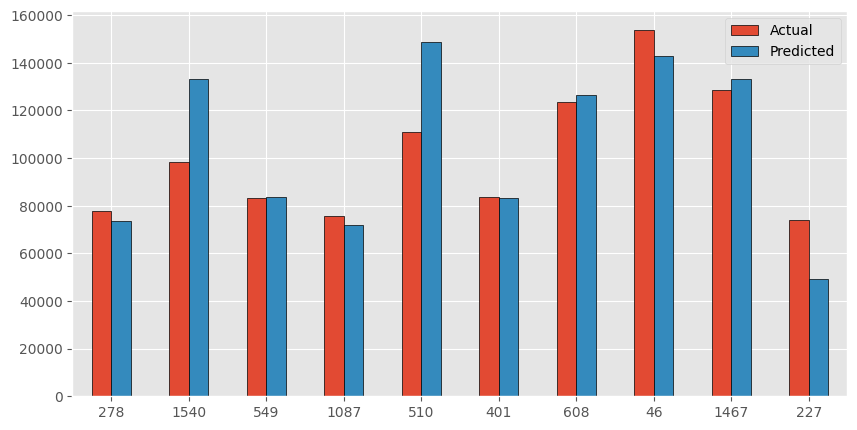

In [146]:
dtr_performance.head(10).plot(kind='bar', figsize=(10,5), 
                              edgecolor='#000000')
plt.xticks(rotation=0)

plt.show();

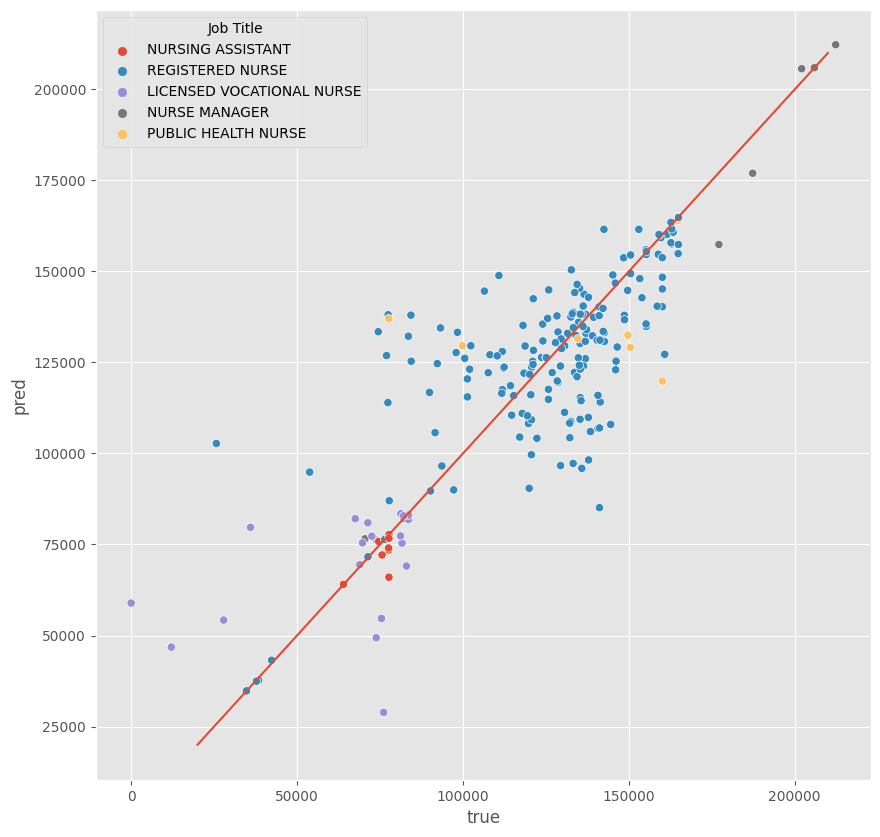

In [147]:
temp_df = pd.DataFrame({'pred':y_preds,'true':y_test,'Job Title':job_test})
plt.figure(figsize=(10,10))
sns.scatterplot(x='true',y='pred',hue='Job Title',data=temp_df)
plt.plot([20000,210000],[20000,210000])

plt.show();

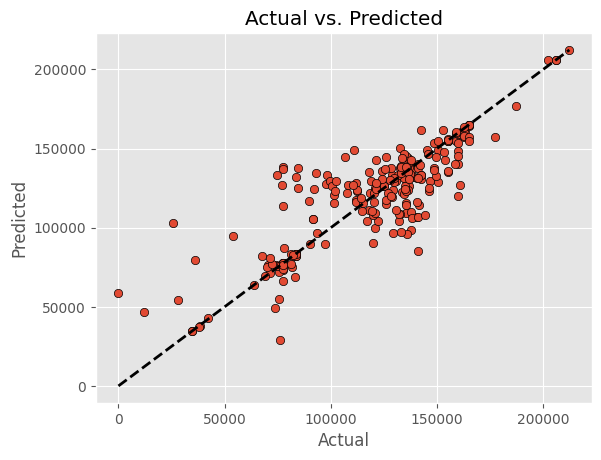

In [148]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_preds, edgecolor='#000000')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
       'k--', lw=2)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs. Predicted')
plt.show();

In [149]:
metrics.mean_squared_error(y_test, y_preds)

366468295.4247701

In [150]:
print(f'Mean Absolute Error: \
      {metrics.mean_absolute_error(y_test, y_preds)}')

print(f'Mean Squared Error: \
      {metrics.mean_squared_error(y_test, y_preds)}')

print(f'R Squared : \
      {metrics.r2_score(y_test, y_preds)}')

print(f'Root Mean Squared Error: \
      {metrics.mean_squared_error(y_test, y_preds, squared=False)}')

#RandomForestRegressor
# Mean Absolute Error:       24023.477857217316
# Mean Squared Error:       1319544551.1777914
# Root Mean Squared Error:       36325.535800285055

Mean Absolute Error:       12540.08457743853
Mean Squared Error:       366468295.4247701
R Squared :       0.7168996916574294
Root Mean Squared Error:       19143.361654233304


## GridSearchCV

In [151]:
from sklearn.model_selection import GridSearchCV

In [152]:
parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1,2,3,4],
}
regr = RandomForestRegressor(random_state=0)

clf = GridSearchCV(regr, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [100, 150, 200, 250, 300]})

In [153]:
#Make predictions of y using X_test
y_preds = clf.predict(X_test)

In [154]:
clf.best_params_

{'max_depth': 4, 'n_estimators': 200}

In [155]:
# KEEP THIS IN MIND
dtr_performance = pd.DataFrame({'Actual': y_test, 'Predicted': y_preds})

In [70]:
dtr_performance.head(10)

,Actual,Predicted
278,77388.87,73886.855388
1540,144067.48,117451.116505
549,86118.13,73886.855388
1087,79420.80,73886.855388
510,119006.53,117637.170405
401,85928.11,73886.855388
608,129560.22,121312.804570
46,93960.26,136982.273353
1467,153481.52,135992.051239
227,77506.21,73886.855388


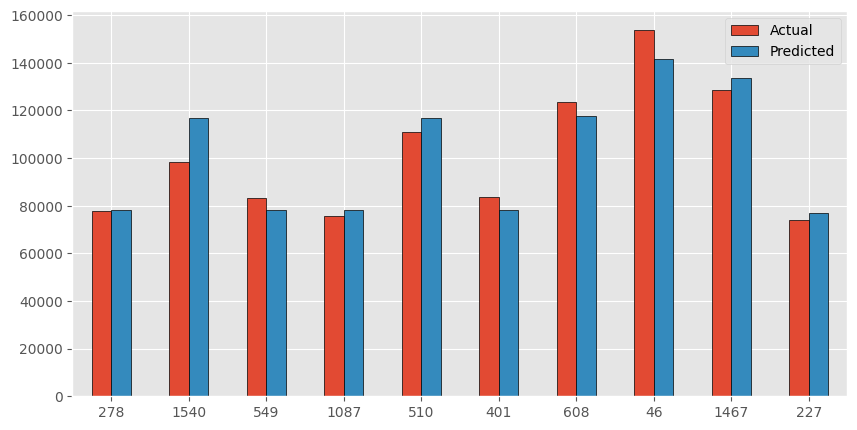

In [156]:
dtr_performance.head(10).plot(kind='bar', figsize=(10,5), 
                              edgecolor='#000000')
plt.xticks(rotation=0)
plt.show();

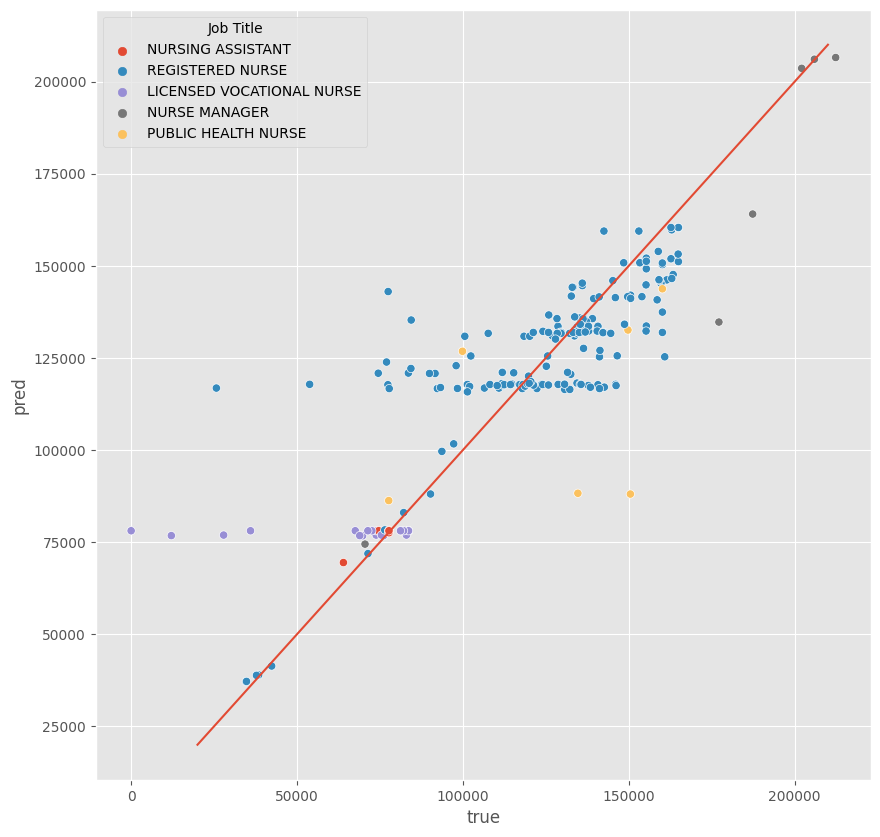

In [157]:
temp_df = pd.DataFrame({'pred':y_preds,'true':y_test,'Job Title':job_test})
plt.figure(figsize=(10,10))
sns.scatterplot(x='true',y='pred',hue='Job Title',data=temp_df)
plt.plot([20000,210000],[20000,210000])
plt.show();

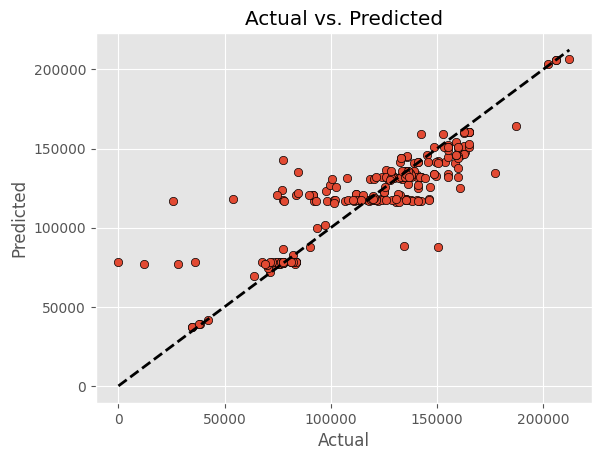

In [158]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_preds, edgecolor='#000000')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
       'k--', lw=2)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs. Predicted')
plt.show();

In [159]:
metrics.mean_squared_error(y_test, y_preds)

334151405.70112604

In [160]:
print(f'Mean Absolute Error: \
      {metrics.mean_absolute_error(y_test, y_preds)}')

print(f'Mean Squared Error: \
      {metrics.mean_squared_error(y_test, y_preds)}')

print(f'R Squared : \
      {metrics.r2_score(y_test, y_preds)}')

print(f'Root Mean Squared Error: \
      {metrics.mean_squared_error(y_test, y_preds, squared=False)}')


# #GridSearchCV
# Mean Absolute Error:       22144.539730013807
# Mean Squared Error:       1129530839.860171
# Root Mean Squared Error:       33608.49356725426

Mean Absolute Error:       11319.369398372472
Mean Squared Error:       334151405.70112604
R Squared :       0.7418648020357558
Root Mean Squared Error:       18279.808688854653


## RandomizedSearchCV

In [161]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [162]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/pornpanthongdee/.pyenv/versions/3.8.13/envs/lewagon2/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [163]:
#Make predictions of y using X_test
y_preds = rf_random.predict(X_test)

In [164]:
# KEEP THIS IN MIND
dtr_performance = pd.DataFrame({'Actual': y_test, 'Predicted': y_preds})

In [165]:
dtr_performance.head(10)

,Actual,Predicted
278,77612.30,71212.549355
1540,98345.17,118992.658540
549,83448.71,82558.802321
1087,75626.07,74722.847860
510,110844.69,123897.652626
401,83602.50,82327.599952
608,123705.08,120623.979811
46,153940.09,141385.733772
1467,128642.99,135350.747182
227,73846.61,54991.760657


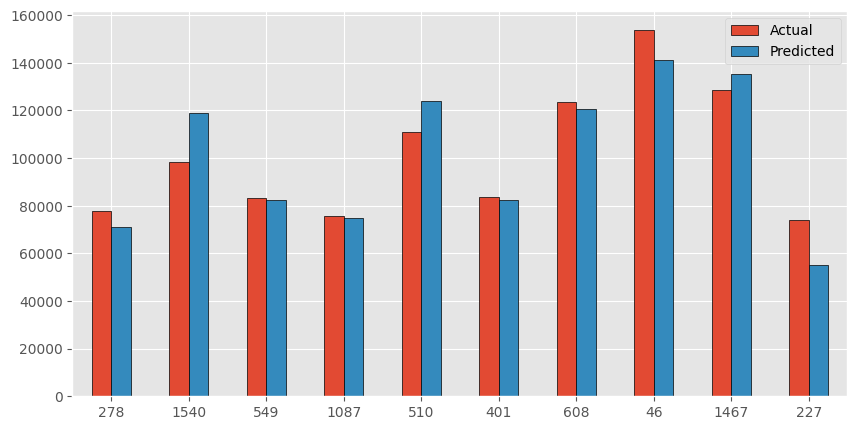

In [166]:
dtr_performance.head(10).plot(kind='bar', figsize=(10,5), 
                              edgecolor='#000000')
plt.xticks(rotation=0)
plt.show();

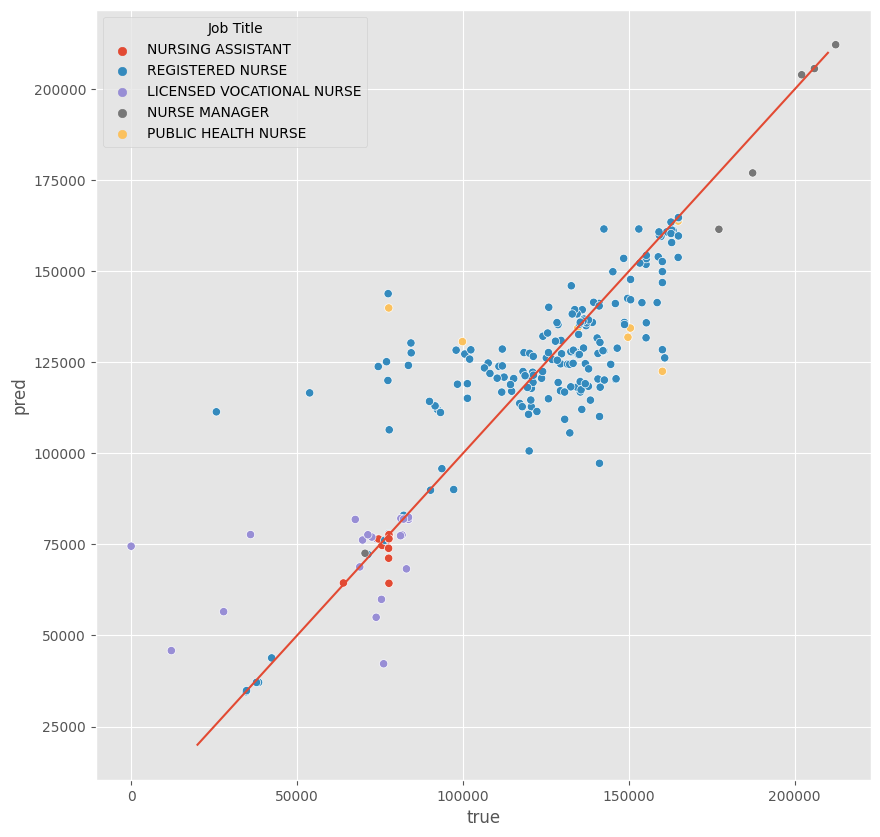

In [167]:
temp_df = pd.DataFrame({'pred':y_preds,'true':y_test,'Job Title':job_test})
plt.figure(figsize=(10,10))
sns.scatterplot(x='true',y='pred',hue='Job Title',data=temp_df)
plt.plot([20000,210000],[20000,210000])
plt.show();

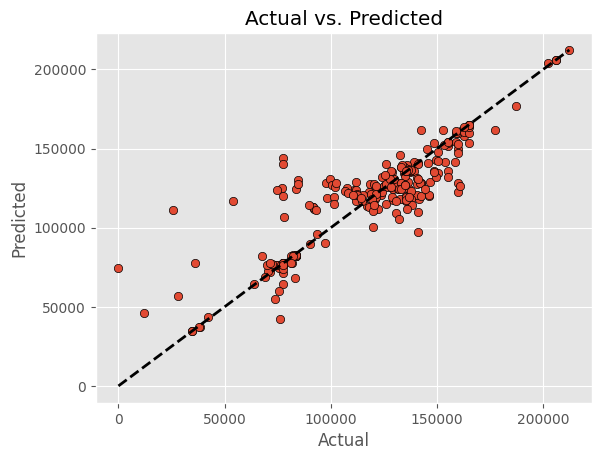

In [168]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_preds, edgecolor='#000000')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
       'k--', lw=2)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs. Predicted')
plt.show();

In [169]:
metrics.mean_squared_error(y_test, y_preds)

314148711.29435086

In [234]:
print(f'Mean Absolute Error: \
      {metrics.mean_absolute_error(y_test, y_preds)}')

print(f'Mean Squared Error: \
      {metrics.mean_squared_error(y_test, y_preds)}')
print(f'R2: \
      {metrics.r2_score(y_test, y_preds)}')


print(f'Root Mean Squared Error: \
      {metrics.mean_squared_error(y_test, y_preds, squared=False)}')
# #RandomizedSearchCV
# Mean Absolute Error:       21923.732227221237
# Mean Squared Error:       1104353284.10478
# Root Mean Squared Error:       33231.81132747326

Mean Absolute Error:       22668.814964701192
Mean Squared Error:       1143187618.7030191
R2:       0.28693512754129014
Root Mean Squared Error:       33811.05763952112


# Model Nurse group 1

In [171]:
from sklearn.model_selection import GridSearchCV

In [172]:
df.columns

Index(['Employee Name', 'Job Title', 'Total Year', 'Start Salary',
       '2018 Salary', 'Increase Rate', '2019 Salary', 'group_job'],
      dtype='object')

In [173]:
df['Job Title'].unique()

array(['REGISTERED NURSE', 'LICENSED VOCATIONAL NURSE', 'NURSE MANAGER',
       'NURSING ASSISTANT', 'PUBLIC HEALTH NURSE'], dtype=object)

In [174]:
def group_nurse(job):
    if job == 'NURSING ASSISTANT' or job == 'LICENSED VOCATIONAL NURSE':
        return 'group1'
    elif job == 'REGISTERED NURSE' or job == 'PUBLIC HEALTH NURSE':
        return 'group2'
    else:
        return 'group3'
    

In [175]:
X_test.columns

Index(['Start Salary', 'Total Year', 'Job Title_NURSE MANAGER',
       'Job Title_NURSING ASSISTANT', 'Job Title_PUBLIC HEALTH NURSE',
       'Job Title_REGISTERED NURSE'],
      dtype='object')

In [176]:
#Create a form in streamlit with 3 input
#Input 1 - Dropdown Option 5 type of nurse
#status=group_job(input1)
# if status=='group1':
#     group1status=1
# else:
#     group1status=0

In [177]:
# Input 2: Total Year = numerica;
# Input 3 Start Sallary=star

In [178]:
# # Load model function as clf
# with open n
# clf.predict([[start_salary, total_year,group1status ]])

In [179]:
df['group_job'] = df['Job Title'].apply(group_nurse)

In [180]:
df_group = pd.get_dummies(df,columns=['group_job'])

In [181]:
df_group

,Employee Name,Job Title,Total Year,Start Salary,2018 Salary,Increase Rate,2019 Salary,group_job_group1,group_job_group2,group_job_group3
0,AACE WU,REGISTERED NURSE,1,79549.99,79549.99,0.000000,56549.07,0,1,0
1,AARON LY,REGISTERED NURSE,4,41509.69,124342.52,1.995506,130451.27,0,1,0
2,AARON R RAINEY,REGISTERED NURSE,6,111472.90,38343.44,-0.656029,68799.78,0,1,0
3,AARON S CRAMER,REGISTERED NURSE,6,115372.35,138890.00,0.203841,143696.20,0,1,0
4,ABIGAIL I ESPINO,LICENSED VOCATIONAL NURSE,6,16254.50,81296.50,4.001477,81491.13,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1607,YVONNE FUENTESPATTISHALL,REGISTERED NURSE,7,119409.99,155264.01,0.300260,164250.50,0,1,0
1608,ZAR N MAW,REGISTERED NURSE,1,64910.38,64910.38,0.000000,93285.77,0,1,0
1609,ZARA GRACE C JANER,REGISTERED NURSE,6,107904.40,148215.14,0.373578,154205.11,0,1,0
1610,ZEXU FANG,REGISTERED NURSE,8,109044.00,155789.00,0.428680,173489.51,0,1,0


In [182]:
df_g1 = df_group[df_group['group_job_group1']==1]
df_g1.head()

,Employee Name,Job Title,Total Year,Start Salary,2018 Salary,Increase Rate,2019 Salary,group_job_group1,group_job_group2,group_job_group3
4,ABIGAIL I ESPINO,LICENSED VOCATIONAL NURSE,6,16254.50,81296.50,4.001477,81491.13,1,0,0
7,ADELFA A PANLASIGUI,LICENSED VOCATIONAL NURSE,6,62084.67,71343.77,0.149137,83290.69,1,0,0
11,AGNES C CASAYURAN,NURSING ASSISTANT,2,75419.32,77658.35,0.029688,79389.71,1,0,0
14,AGNES TRINIDAD,NURSING ASSISTANT,4,70245.00,77695.20,0.106060,80018.90,1,0,0
34,ALEXANDER S PALACIO,NURSING ASSISTANT,4,70236.34,77704.00,0.106322,74861.15,1,0,0


In [183]:
X = df_g1[['Start Salary','Total Year', 'group_job_group1']]
y = df_g1['2019 Salary']


In [184]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=42)

In [185]:
lr1 = LinearRegression()
lr1.fit(X_train,y_train)

lr1.score(X_train, y_train)

0.3115327504970691

In [186]:
regr1 = RandomForestRegressor(max_depth=4)

regr1.fit(X_train, y_train)
regr1.score(X_train, y_train)
regr1.score(X_test,y_test)

0.16471134561099754

In [187]:
y_preds = regr1.predict(X_test)

In [188]:
r2_score(y_test,y_preds)

0.16471134561099754

In [190]:
mean_squared_error(y_test, y_preds, squared=False)

14315.166812443736

In [105]:
parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1,2,3,4],
}
regr = RandomForestRegressor(random_state=0)

clf1 = GridSearchCV(regr, parameters)
clf1.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [100, 150, 200, 250, 300]})

In [106]:
clf1.best_params_

{'max_depth': 1, 'n_estimators': 300}

In [107]:
#Make predictions of y using X_test
y_preds = clf1.predict(X_test)

In [108]:
# KEEP THIS IN MIND
dtr_performance = pd.DataFrame({'Actual': y_test, 'Predicted': y_preds})

In [109]:
dtr_performance.head(10)

,Actual,Predicted
178,19285.35,77255.867112
730,80028.00,73790.729279
488,78583.80,73287.088013
835,80322.50,73757.972269
1190,80018.90,73287.088013
911,79820.05,77223.110103
1266,85424.59,77255.867112
273,86098.40,77255.867112
1035,86108.20,73287.088013
1491,86092.31,73188.684612


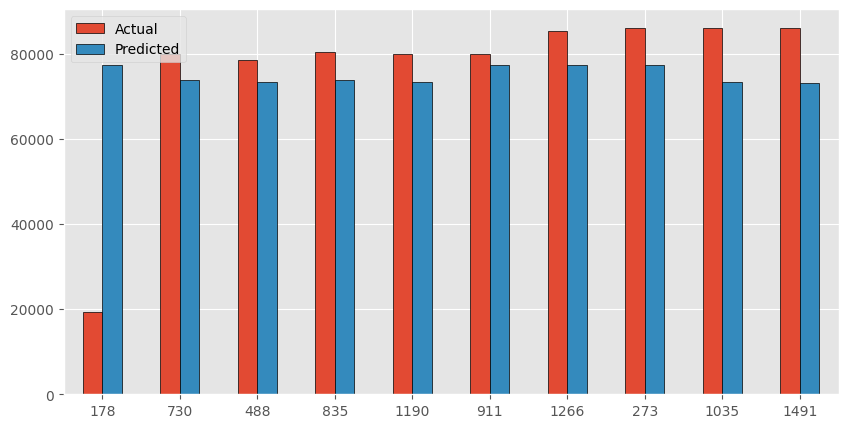

In [110]:
dtr_performance.head(10).plot(kind='bar', figsize=(10,5), 
                              edgecolor='#000000')
plt.xticks(rotation=0)
plt.show();

In [112]:
# temp_df = pd.DataFrame({'pred':y_preds,'true':y_test,'Job Title':job_test})
# plt.figure(figsize=(10,10))
# sns.scatterplot(x='true',y='pred',hue='Job Title',data=temp_df)
# plt.plot([20000,210000],[20000,210000])
# evaluate(dtr, X_test=X_test_sc)
# plt.show();



In [ ]:
mean_squared_error(y_test, y_preds, squared=False)

In [ ]:
r2_score(y_test,y_preds)

In [ ]:
##########################
# SAVE-LOAD using pickle #
##########################
import pickle

# save
with open('model_group1.pkl','wb') as f:
    pickle.dump(clf1,f)

In [ ]:
ls

In [ ]:
# load
with open('model_group1.pkl', 'rb') as f:
    clf = pickle.load(f)

clf.predict(X_test)

In [ ]:
X_test.columns

# Model Nurse group 2

In [ ]:
df_group

In [ ]:
df_g2 = df_group[df_group['group_job_group2']==1]
df_g2.head()

In [ ]:
X

In [ ]:
X = df_g2[['Start Salary', 'Total Year', 'group_job_group2']]
y = df_g2['2019 Salary']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=42)

In [ ]:
regr = RandomForestRegressor(max_depth=4)

regr.fit(X_train, y_train)
regr.score(X_train, y_train)
regr.score(X_test,y_test)

In [ ]:
# y_preds = regr.predict(X_test)

In [ ]:
parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1,2,3,4],
}
regr = RandomForestRegressor(random_state=0)

clf2 = GridSearchCV(regr, parameters)
clf2.fit(X_train, y_train)

In [ ]:
#Make predictions of y using X_test
y_preds = clf2.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_preds, squared=False)

In [ ]:
r2_score(y_test,y_preds)

#  Model Nurse group 3

In [ ]:
df_g3 = df_group[df_group['group_job_group3']==1]
df_g3.head()

In [ ]:
df_g3.shape

In [ ]:
X = df_g3[['Start Salary', 'Total Year', 'group_job_group3']]
y = df_g3['2019 Salary']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=42)

In [ ]:
regr = RandomForestRegressor(max_depth=4)

regr.fit(X_train, y_train)
regr.score(X_train, y_train)
regr.score(X_test,y_test)


In [ ]:
parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1,2,3,4],
}
regr = RandomForestRegressor(random_state=0)

clf2 = GridSearchCV(regr, parameters)
clf2.fit(X_train, y_train)

In [ ]:
#Make predictions of y using X_test
y_preds = clf2.predict(X_test)

In [ ]:
mean_squared_error(y_test, y_preds, squared=False)

In [ ]:
r2_score(y_test,y_preds)

In [ ]:
#Make predictions of y using X_test
y_preds = clf2.predict(X_test)

In [ ]:
# KEEP THIS IN MIND
dtr_performance = pd.DataFrame({'Actual': y_test, 'Predicted': y_preds})

In [191]:
dtr_performance.head(10)

,Actual,Predicted
278,77612.30,71212.549355
1540,98345.17,118992.658540
549,83448.71,82558.802321
1087,75626.07,74722.847860
510,110844.69,123897.652626
401,83602.50,82327.599952
608,123705.08,120623.979811
46,153940.09,141385.733772
1467,128642.99,135350.747182
227,73846.61,54991.760657
